<a href="https://colab.research.google.com/github/elaine2233/ICH/blob/main/ResNet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import random
random.seed(12345)

In [ ]:
#librarys
!pip install dicom
import dicom

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from tensorflow.keras import layers # just randommmmm
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, MaxPooling2D, Dropout

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.resnet import ResNet101



import numpy as np
import pandas as pd

import math
import argparse
import cv2
import os

from matplotlib import pyplot
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize

from collections import Counter

#Evaluation
from sklearn import metrics
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc


     |████████████████████████████████| 766 kB 7.0 MB/s 


/usr/local/lib/python3.7/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Connect to google drive and google cloud

## connect to google drive

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract type y
# import pandas as pd
typey0 = pd.read_csv('/content/drive/MyDrive/CHL7001/GroupProject/Data/train/stage2train_wide_posneg.csv')
typey0['ID'] = 'ID_' + typey0['ID2'].astype(str)
typey0['IDpng'] = typey0['ID'].astype(str) + '.png'
typey0 = typey0[typey0.ID != 'ID_6431af929']
typey0[:5]

,Unnamed: 0,ID2,any,ID,IDpng
0,1,000012eaf,0,ID_000012eaf,ID_000012eaf.png
1,2,000039fa0,0,ID_000039fa0,ID_000039fa0.png
2,3,00005679d,0,ID_00005679d,ID_00005679d.png
3,4,00008ce3c,0,ID_00008ce3c,ID_00008ce3c.png
4,5,0000950d7,0,ID_0000950d7,ID_0000950d7.png


In [ ]:
# Patient ID
# import pandas as pd
pid = pd.read_csv('/content/drive/MyDrive/CHL7001/GroupProject/Data/train/stage_2_train_with_metadata.csv')
typey = pd.merge(typey0,pid,on='ID',how='left')
typey = typey.sort_values('PatientID')
typey[:5]

,Unnamed: 0,ID2,any,ID,IDpng,PatientID
108780,108781,24f7cfc41,0,ID_24f7cfc41,ID_24f7cfc41.png,ID_0002cd41
3397,3398,012b0d238,0,ID_012b0d238,ID_012b0d238.png,ID_0002cd41
86943,86944,1d88058ff,0,ID_1d88058ff,ID_1d88058ff.png,ID_0002cd41
689375,689377,ea722c4e5,0,ID_ea722c4e5,ID_ea722c4e5.png,ID_0002cd41
81401,81402,1b9de2922,0,ID_1b9de2922,ID_1b9de2922.png,ID_0002cd41


In [ ]:
#calculate patient level sum
UnqPID = pd.DataFrame({'Sum_img':pid.groupby(['PatientID']).size()}).reset_index()
np.random.seed(111111)
UnqPID = UnqPID.sample(frac=1)
UnqPID['Cum_sum'] = UnqPID['Sum_img'].cumsum()
UnqPID[:5],typey[:5]

(         PatientID  Sum_img  Cum_sum
 9239   ID_7c597aae       32       32
 16164  ID_daa1d81f       39       71
 11231  ID_964cfda8       32      103
 3128   ID_2976ee63       34      137
 13010  ID_af0cb503       32      169,
         Unnamed: 0        ID2  any            ID             IDpng    PatientID
 108780      108781  24f7cfc41    0  ID_24f7cfc41  ID_24f7cfc41.png  ID_0002cd41
 3397          3398  012b0d238    0  ID_012b0d238  ID_012b0d238.png  ID_0002cd41
 86943        86944  1d88058ff    0  ID_1d88058ff  ID_1d88058ff.png  ID_0002cd41
 689375      689377  ea722c4e5    0  ID_ea722c4e5  ID_ea722c4e5.png  ID_0002cd41
 81401        81402  1b9de2922    0  ID_1b9de2922  ID_1b9de2922.png  ID_0002cd41)

## connect to google cloud

In [ ]:
# connect to google cloud
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

# Extract Data

In [ ]:
!gsutil cp gs://chl7001gp_bucket_png_128/image_png.zip . 

Copying gs://chl7001gp_bucket_png_128/image_png.zip...
\ [1 files][  3.3 GiB/  3.3 GiB]   32.5 MiB/s                                   
Operation completed over 1 objects/3.3 GiB.                                      


In [ ]:
#unzip full data
!unzip /content/image_png.zip

In [ ]:
datapath = '/content/kaggle/working/output/stage_2_train'

In [ ]:
# import math
# def roundup(x):
#   return int(math.ceil(x / 100.0)) * 100

# Image preparation

In [ ]:
# datapath = '/content/kaggle/working/output/stage_2_train'


#check length of image
imglist = os.listdir(datapath) # dir is your directory path
number_files = len(imglist)
print(number_files)

752802


In [ ]:
number_y = typey.shape[0]
print(number_y)

752802


In [ ]:
# import math
# number_y = 720728
ntrain0 = math.ceil(number_y*0.7)

#select every thing till 70%
trainPID = UnqPID[UnqPID['Cum_sum']<ntrain0]['PatientID'].tolist()

trainy_name = typey[typey['PatientID'].isin(trainPID)]['ID']
testy_name = typey[-typey['PatientID'].isin(trainPID)]['ID']

trainy = typey[typey['PatientID'].isin(trainPID)]['any'].tolist()
testy = typey[-typey['PatientID'].isin(trainPID)]['any'].tolist()
trainy = np.array(trainy)
testy = np.array(testy)

ntrain = trainy_name.shape[0]
nsuptrain = math.ceil(ntrain*0.1)
ntest = testy_name.shape[0]

print(ntrain,ntest, nsuptrain, len(trainy_name),len(testy_name), trainy.shape,testy.shape)

526952 225850 52696 526952 225850 (526952,) (225850,)


In [ ]:
trainy_name[trainy_name == 'ID_6431af929'],testy_name[testy_name == 'ID_6431af929']

(Series([], Name: ID, dtype: object), Series([], Name: ID, dtype: object))

In [ ]:
#check if patient in train is in test
trainuqpid = typey[typey['PatientID'].isin(trainPID)]['PatientID'].unique()
testuqpid = typey[-typey['PatientID'].isin(trainPID)]['PatientID'].unique()

np.intersect1d(trainuqpid,testuqpid)

array([], dtype=object)

In [ ]:
typey = typey[typey['IDpng'].isin(imglist)]
typey.shape

(752802, 6)

In [ ]:
len(trainy_name),trainy.shape

(526952, (526952,))

In [ ]:
trainy_name[:5]

108780    ID_24f7cfc41
3397      ID_012b0d238
86943     ID_1d88058ff
689375    ID_ea722c4e5
81401     ID_1b9de2922
Name: ID, dtype: object

In [ ]:
#summary of trainy and testy
# from collections import Counter
Counter(trainy),Counter(testy)

(Counter({0: 451777, 1: 75175}), Counter({0: 193092, 1: 32758}))

# Model

In [ ]:
#split trainy trainy_name testy testy_name to postive and negative
trainy1 = trainy[trainy == 1]
trainy0 = trainy[trainy == 0]

trainy_name1 = trainy_name[trainy == 1]
trainy_name0 = trainy_name[trainy == 0]

testy1 = testy[testy == 1]
testy0 = testy[testy == 0]

testy_name1 = testy_name[testy == 1]
testy_name0 = testy_name[testy == 0]


In [ ]:
testy_name1[:5],testy_name0[:5],testy1[:5],testy0[:5],testy_name1.shape,len(testy1),testy_name0.shape,len(testy0),trainy_name0.shape,trainy_name1.shape

(618197    ID_d215015bb
 303715    ID_670751ba1
 718390    ID_f45235460
 131382    ID_2ca2ce2e7
 180044    ID_3d22dc4b0
 Name: ID, dtype: object, 84504     ID_1cb815aae
 278929    ID_5e91fea15
 270174    ID_5bb0651bd
 556669    ID_bd0eb5226
 182438    ID_3df0d63c3
 Name: ID, dtype: object, array([1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0]), (32758,), 32758, (193092,), 193092, (451777,), (75175,))

In [ ]:
from tensorflow.keras.utils import to_categorical

trainy_hot = to_categorical(trainy)
testy_hot = to_categorical(testy)

trainy_hot1 = to_categorical(trainy1)
trainy_hot0 = to_categorical(np.append(1, trainy0))[1:]

testy_hot1 = to_categorical(testy1)
testy_hot0 = to_categorical(np.append(1, testy0))[1:]

## Custom Generator

In [ ]:
# import tensorflow
class My_Custom_Generator(tf.keras.utils.Sequence):
  
  def __init__(self, image_filenames, image_filenames0, image_filenames1, labels0, labels1, batch_size, batch_size0, batch_size1) :
    self.image_filenames = image_filenames
    self.image_filenames0 = image_filenames0
    self.image_filenames1 = image_filenames1
    self.labels0 = labels0
    self.labels1 = labels1
    self.batch_size = batch_size
    self.batch_size0 = batch_size0
    self.batch_size1 = batch_size1
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  # split train -+, extract from both list, shuff
  def __getitem__(self, idx):
    rdm_seed = random.randint(0,1000)
    np.random.seed(rdm_seed)
    np.random.permutation(self.image_filenames0)
    np.random.permutation(self.image_filenames1)

    batch_x0 = self.image_filenames0[(idx*self.batch_size0) : ((idx+1)*self.batch_size0)]
    batch_x1 = self.image_filenames1[(idx*self.batch_size1) : ((idx+1)*self.batch_size1)]
    batch_x = batch_x0.append(batch_x1)

    batch_y0 = self.labels0[(idx * self.batch_size0) : ((idx+1) * self.batch_size0)]
    batch_y1 = self.labels1[(idx * self.batch_size1) : ((idx+1) * self.batch_size1)]
    batch_y = np.concatenate([batch_y0,batch_y1])
    
    return (np.array([
            resize(imread(datapath + '/' + str(file_name)+ '.png'), (128, 128, 3))
               for file_name in batch_x])- 127.5)/127.5, np.array(batch_y)

In [ ]:
# import tensorflow
class Test_Generator(tf.keras.utils.Sequence):
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  # split train -+, extract from both list, shuff
  def __getitem__(self, idx):
    batch_x = self.image_filenames[(idx*self.batch_size) : ((idx+1)*self.batch_size)]
    batch_y = self.labels[(idx * self.batch_size) : ((idx+1) * self.batch_size)]
    
    return (np.array([
            resize(imread(datapath + '/' + str(file_name)+ '.png'), (128, 128, 3))
               for file_name in batch_x])- 127.5)/127.5, np.array(batch_y)

In [ ]:
batch_size = 50
prop = 0.5
batch_size0 = int(batch_size*(1-prop))
batch_size1 = int(batch_size*prop)
# ntest = ntrain = 10000
ntrain = len(trainy1)*2

my_training_batch_generator = My_Custom_Generator(trainy_name[:ntrain], trainy_name0,trainy_name1, trainy_hot0,trainy_hot1, batch_size, batch_size0,batch_size1)
my_validation_batch_generator = Test_Generator(testy_name[:ntest], testy_hot[:ntest], batch_size)

## ResNet

In [ ]:
# import numpy as np
# import pandas as pd

# from skimage.io import imread
# from skimage.transform import resize

# from tensorflow.keras.utils import Sequence
# from tensorflow.keras.models import Sequential, Model, load_model
# from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.utils import to_categorical

# import tensorflow as tf
# from tensorflow.keras.applications.resnet import ResNet101

In [ ]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 128
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

In [ ]:

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet101(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

171450368/171446536 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 42,662,274
Trainable params: 4,098
Non-trainable params: 42,658,176
_________________________________________________________________


## model fit

In [ ]:
H = model.fit(my_training_batch_generator,
                        steps_per_epoch = int(ntrain//batch_size),
                        epochs = 1,
                        verbose = 1,
                        validation_data = my_validation_batch_generator,
                        validation_steps = int(ntest//batch_size))
# run 2/3 epochs, shorter epochs (not run all data) (eg. steps_per_epoch smaller)

3007/3007 [==============================] - 4023s 1s/step - loss: 0.6931 - accuracy: 0.5877 - val_loss: 0.6920 - val_accuracy: 0.6726


In [ ]:
model.save('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf',save_format='tf')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf/assets


In [ ]:
model_epoch2 = tf.keras.models.load_model('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf')

In [ ]:
H_epoch2 = model_epoch2.fit(my_training_batch_generator,
                        steps_per_epoch = int(ntrain//batch_size),
                        epochs = 1,
                        verbose = 1,
                        validation_data = my_validation_batch_generator,
                        validation_steps = int(ntest//batch_size))

3007/3007 [==============================] - 3585s 1s/step - loss: 0.6916 - accuracy: 0.6120 - val_loss: 0.6862 - val_accuracy: 0.7717


In [ ]:
model_epoch2.save('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch2',save_format='tf')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch2/assets


In [ ]:
model_epoch3 = tf.keras.models.load_model('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch2')

In [ ]:
H_epoch3 = model_epoch3.fit(my_training_batch_generator,
                        steps_per_epoch = int(ntrain//batch_size),
                        epochs = 1,
                        verbose = 1,
                        validation_data = my_validation_batch_generator,
                        validation_steps = int(ntest//batch_size))

3007/3007 [==============================] - 4244s 1s/step - loss: 0.6900 - accuracy: 0.6260 - val_loss: 0.6832 - val_accuracy: 0.7586


In [ ]:
model_epoch3.save('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch3',save_format='tf')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch3/assets


In [ ]:
model_epoch4 = tf.keras.models.load_model('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch3')

In [ ]:
H_epoch4 = model_epoch4.fit(my_training_batch_generator,
                        steps_per_epoch = int(ntrain//batch_size),
                        epochs = 1,
                        verbose = 1,
                        validation_data = my_validation_batch_generator,
                        validation_steps = int(ntest//batch_size))

3007/3007 [==============================] - 3570s 1s/step - loss: 0.6888 - accuracy: 0.6304 - val_loss: 0.6811 - val_accuracy: 0.7456


In [ ]:
model_epoch4.save('/content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch4',save_format='tf')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CHL7001/GroupProject/Model/MyModel_ResNet_alldata_tf_epoch4/assets


In [ ]:
model = model_epoch3
H = H_epoch4

## Prediction

In [ ]:
predIdxs = model.predict(my_validation_batch_generator, batch_size=50)
predIdxs2 = np.argmax(predIdxs, axis=1)

In [ ]:
predIdxs[:50]

array([[0.502073  , 0.497927  ],
       [0.50052583, 0.4994741 ],
       [0.50778323, 0.49221683],
       [0.50147855, 0.49852148],
       [0.5076795 , 0.49232045],
       [0.5053738 , 0.49462622],
       [0.5115119 , 0.48848808],
       [0.5002187 , 0.49978134],
       [0.49980536, 0.5001946 ],
       [0.51249415, 0.48750582],
       [0.50252086, 0.4974791 ],
       [0.5077875 , 0.4922125 ],
       [0.50134146, 0.49865857],
       [0.50147057, 0.49852943],
       [0.49935493, 0.5006451 ],
       [0.5011795 , 0.4988205 ],
       [0.5107286 , 0.48927137],
       [0.5018778 , 0.49812225],
       [0.5069486 , 0.49305144],
       [0.5067438 , 0.49325627],
       [0.5042076 , 0.49579242],
       [0.50162476, 0.49837524],
       [0.49872172, 0.5012783 ],
       [0.50567997, 0.49432003],
       [0.5041328 , 0.49586716],
       [0.511571  , 0.48842898],
       [0.49976173, 0.5002383 ],
       [0.5018699 , 0.49813005],
       [0.50177455, 0.49822545],
       [0.51077986, 0.48922014],
       [0.

In [ ]:
# from collections import Counter
Counter(predIdxs2),Counter(testy[:ntest])

(Counter({0: 189720, 1: 36130}), Counter({0: 193092, 1: 32758}))

# Evaluation

In [ ]:
#evaluation function
# from sklearn import metrics
# from sklearn.metrics import roc_auc_score 
def FEvaluatation(model,ntest,pred_prob,pred,testy):

  #confusion matrix
  confusion = metrics.confusion_matrix(testy[:ntest], pred_prob)

  #ROC
  AUC = metrics.roc_auc_score(testy[:ntest], pred[:,1]) # AUC score
  
  print(confusion,AUC)

In [ ]:
FEvaluatation(model,ntest,predIdxs2,predIdxs,testy)

[[165625  27467]
 [ 24095   8663]] 0.6844651957973922


in one function, recall, spec, 

## Confusion Matrix

In [ ]:
# from sklearn import metrics
# from sklearn.metrics import roc_auc_score 

In [ ]:
# confusion matrix - simple version

  # y_pred_class is the class predictions for the testing set
  # a vector of 0s and 1s

confusion = metrics.confusion_matrix(testy[:ntest], predIdxs2)
print(confusion)
#[row, column]

[[165625  27467]
 [ 24095   8663]]


In [ ]:
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
sensitivity = TP / float(FN + TP)

print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(testy[:ntest], predIdxs2))
print(sensitivity)

0.7716980296657073
0.7716980296657073
0.2644544844007571


## ROC

0.6844651957973922


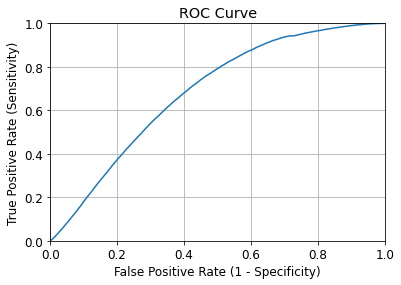

In [ ]:
# ROC curve

# "y_test" should be the y(label) values in the testing sets, 
# a vector of 0s and 1s

# "y_pred_prob" is the stored predicted probabilities for class 1 
# Class 1 means true

fpr, tpr, thresholds = metrics.roc_curve(testy[:ntest], predIdxs[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(metrics.roc_auc_score(testy[:ntest], predIdxs[:,1])) # AUC score

In [ ]:
accuracy = accuracy_score(#test_generator.classes, #y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

## Learn Rate

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from plot_conf_matr import plot_confusion_matrix

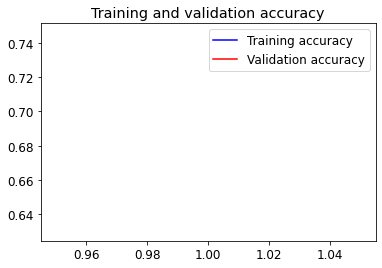

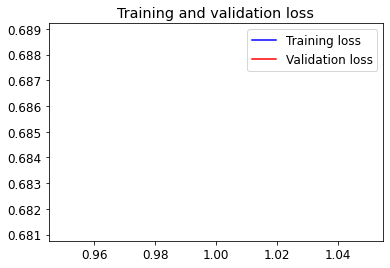

In [ ]:
# learning curves

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

## Precision and Recall

Logistic: f1=0.252 auc=0.220


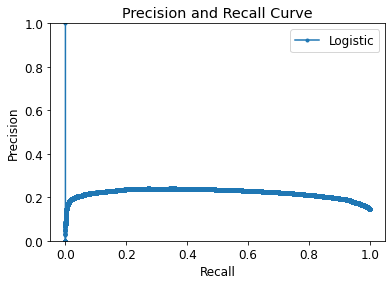

0.2644544844007571


In [ ]:
# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import f1_score
# from sklearn.metrics import auc
# from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(testy[:ntest], predIdxs[:,1])
lr_f1, lr_auc = f1_score(testy[:ntest], predIdxs2), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

pyplot.ylim([0.0, 1.0])
pyplot.title('Precision and Recall Curve')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

print(metrics.recall_score(testy[:ntest], predIdxs2)) # Recall score

## Comparison for FP and FN

In [ ]:
typey0 = pd.read_csv('/content/drive/MyDrive/CHL7001/GroupProject/Data/train/stage_2_train.csv')


In [ ]:
img_FP_lst = testy_name[predIdxs2>testy]

In [ ]:
img_FN_lst = testy_name[predIdxs2<testy]

In [ ]:
# img_FN_lst.values[49]

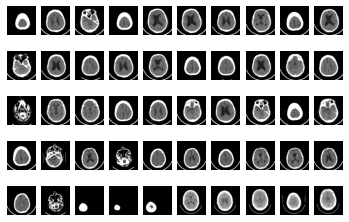

In [ ]:
import matplotlib.pyplot as plt

rows, cols = 5, 10
i = 1

for img_FP in img_FP_lst[:50]:
  img = tf.keras.preprocessing.image.load_img(os.path.join(datapath,str(img_FP) + '.png'))
  ax = plt.subplot(rows, cols, i)
  plt.imshow(img)
  plt.axis('off')
  i+=1

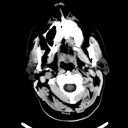

In [ ]:
tf.keras.preprocessing.image.load_img(os.path.join(datapath,str(img_FP_lst.values[20]) + '.png'))

In [ ]:
typey0[typey0['ID'].str.contains(img_FP_lst.values[20])]

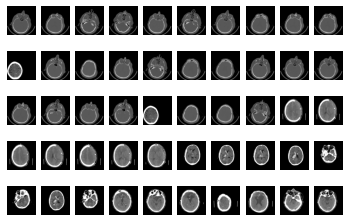

In [ ]:
rows, cols = 5, 10
i = 1

for img_FN in img_FN_lst[:50]:
  img = tf.keras.preprocessing.image.load_img(os.path.join(datapath,str(img_FN) + '.png'))
  ax = plt.subplot(rows, cols, i)
  plt.imshow(img)
  plt.axis('off')
  i+=1


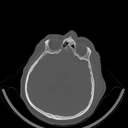

In [ ]:
tf.keras.preprocessing.image.load_img(os.path.join(datapath,str(img_FN_lst.values[1]) + '.png'))

In [ ]:
typey0[typey0['ID'].str.contains(img_FN_lst.values[1])]

,ID,Label
4380714,ID_670751ba1_epidural,0
4380715,ID_670751ba1_intraparenchymal,0
4380716,ID_670751ba1_intraventricular,0
4380717,ID_670751ba1_subarachnoid,0
4380718,ID_670751ba1_subdural,1
4380719,ID_670751ba1_any,1
